# Transfer Learning - Flower Classification

First, We should install & import all packages

In [168]:
%pip install torch
%pip install torchvision
%pip install scipy 
%pip install torchsummary
%pip install tqdm 
%pip install opencv-python
%pip install albumentations==0.4.6

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [23]:
%pip install pandas

  Using cached pandas-1.4.2-cp38-cp38-win_amd64.whl (10.6 MB)
  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\david\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [24]:
import pandas as pd
import torch
import torchvision
from tqdm import tqdm
import glob
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A  
import scipy.io
from functools import cmp_to_key
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor
import torchvision.models as models
from torchvision.io import read_image
from torchsummary import summary 
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
import json
import matplotlib.pyplot as plt


## Lets Fech The Data

In [171]:
labels = scipy.io.loadmat('imagelabels.mat')['labels'][0]
imgs_path = glob.glob("jpg/*")

### Sort For Easy Excess

In [172]:
def cmp_file_names(item1, item2):
    item1 = int(item1.split("_")[1].replace('.jpg',''))
    item2 = int(item2.split("_")[1].replace('.jpg',''))   
    return item1 - item2
imgs_path = np.array(sorted(imgs_path,key=cmp_to_key(cmp_file_names)))
labels = np.array(labels)

#### Combine Path & labels

In [173]:
def divide_train_test_split(test_size=0.25,val_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split(imgs_path, labels, test_size=test_size, random_state=1)
    val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=1) 
    return {
        'train': (X_train,y_train),
        'validation': (X_val,y_val),
        'test': (X_test,y_test),
    }
divide_train_test_split()

{'train': (array(['jpg\\image_06462.jpg', 'jpg\\image_04103.jpg',
         'jpg\\image_02324.jpg', ..., 'jpg\\image_04255.jpg',
         'jpg\\image_00974.jpg', 'jpg\\image_03638.jpg'], dtype='<U19'),
  array([33, 29, 43, ..., 18, 46, 72], dtype=uint8)),
 'validation': (array(['jpg\\image_04100.jpg', 'jpg\\image_06602.jpg',
         'jpg\\image_03642.jpg', ..., 'jpg\\image_05294.jpg',
         'jpg\\image_06449.jpg', 'jpg\\image_04543.jpg'], dtype='<U19'),
  array([29, 25, 53, ..., 70, 33, 71], dtype=uint8)),
 'test': (array(['jpg\\image_03892.jpg', 'jpg\\image_06722.jpg',
         'jpg\\image_03415.jpg', ..., 'jpg\\image_04550.jpg',
         'jpg\\image_06489.jpg', 'jpg\\image_04493.jpg'], dtype='<U19'),
  array([17, 79, 23, ..., 71, 26, 71], dtype=uint8))}

### Import Pretrained Model

In [174]:
vgg16 = models.vgg16(pretrained=True)
alexnet= models.alexnet(pretrained=True)

N_CLASS = 102


In [175]:
for param in vgg16.classifier[6].parameters():
    param.requires_grad = True
for param in alexnet.classifier[6].parameters():
    param.requires_grad = True


Crete the customize network and visulize it

In [176]:
classifer1 = torch.nn.Sequential(
    vgg16,
    torch.nn.Linear(in_features=1_000,out_features=N_CLASS),
)

classifer2 = torch.nn.Sequential(
    alexnet,
    torch.nn.Linear(in_features=1_000,out_features=N_CLASS),
)

In [177]:
summary(classifer1, (3, 224, 224))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [178]:
summary(classifer2, (3, 224, 224))  

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

After building the model we should define all hyper paramters

we almost there, the only need is to import and use the data. Torch uses Dataset & DataLoader,
To do Just that! 

In [179]:
class ImgDataset(Dataset):
    
    def __init__(self, data_tuple, transform, target_transform=None):
        self.imgs_path, self.labels = data_tuple
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
        # return 20

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        transformed = self.transform(image=img)
        img = transformed['image']
        img = T.Resize(IMG_SIZE)(img)
        label = torch.zeros((N_CLASS))
        label[self.labels[idx]-1] = 1
        return img, label.float()
    

we need to create the data loader each time for diffrent eval & test for each epoch

In [180]:
def create_data_splits(transform):
    data_dict = divide_train_test_split()
    new_dict = dict()
    for key,val in data_dict.items():
        ds = ImgDataset(val,transform)
        new_dict[key] = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
    return new_dict

In [181]:
def accuracy(predictions,labels):
    return torch.sum(torch.argmax(labels,axis=1) ==  torch.argmax(predictions,axis=1)) / labels.size()[0]

#### Training | Test | Validation Loop

In [182]:
def train(train_loader,model,optimizer,criterion):
    model.train()
    running_loss = 0.
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss


In [183]:
def validation(validation_loader,model,criterion):
    model.eval()
    acc, running_loss = 0 , 0
    for inputs, labels in validation_loader: 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        acc += accuracy(outputs, labels)
    return running_loss, int(acc)


In [184]:
def train_validation(train_loader,validation_loader,model,optimizer,criterion,epoch_num=1):
    model.train()
    meta_by_epoch = {
        'train': { 'loss': []},
        'validation': { 'loss': [], 'accuracy': []},
    }
    for ep in range(epoch_num):
        meta_by_epoch['train']['loss'].append(train(train_loader,model,optimizer,criterion))
        val_data = validation(validation_loader,model,criterion)
        meta_by_epoch['validation']['loss'].append(val_data[0])
        meta_by_epoch['validation']['accuracy'].append(val_data[1])
    return meta_by_epoch


In [185]:
def test(test_loader,model,optimizer,criterion):
    model.eval()
    acc, running_loss = 0 , 0
    for inputs, labels in test_loader: 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        acc += accuracy(outputs, labels)
        
    return running_loss , int(acc)

In [186]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [187]:
transforms_train = A.Compose([
    A.RandomResizedCrop(height=IMG_SIZE[0],width=IMG_SIZE[1],p=0.2),
    A.Normalize(),   
    A.Flip(),# normalize
    ToTensorV2(),
    # shift channels to be first rather than last and convert to torch tensor
]) 

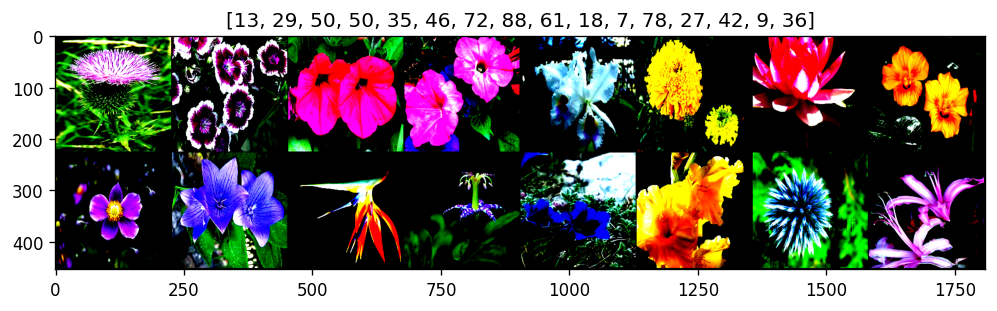

In [188]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    plt.figure(figsize=(10, 10), dpi=120)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)# pause a bit so that plots are updated
    pass

data = create_data_splits(transforms_train)
# # Get a batch of training data
inputs, classes = next(iter(data['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[ int(torch.argmax(x)) for x in classes])

In [189]:
def runner(classifer,transform,n_epochs):
    optimizer = torch.optim.SGD(classifer.parameters(), lr=0.001, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()
    runinng_meta = []
    for r_n in range(2):
        data = create_data_splits(transform)
        meta = train_validation(data['train'],data['validation'],classifer,optimizer,criterion,epoch_num=5)
        test_data = test(data['test'],classifer,optimizer,criterion)
        meta['test'] = {}
        meta['test']['loss'] = test_data[0]
        meta['test']['accuracy'] = test_data[1]
        print("+++++++++++")
        print(meta)
        print("+++++++++++")
        runinng_meta.append(meta)
    return runinng_meta


In [190]:
vgg_data = runner(classifer=classifer1,transform=transforms_train,n_epochs=5)
alexnet_data = runner(classifer=classifer2,transform=transforms_train,n_epochs=5)

+++++++++++
{'train': {'loss': [712.8543820381165]}, 'validation': {'loss': [163.65757912397385], 'accuracy': [85]}, 'test': {'loss': 160.71865034103394, 'accuracy': 87}}
+++++++++++
+++++++++++
{'train': {'loss': [283.9853145927191]}, 'validation': {'loss': [112.13332645595074], 'accuracy': [97]}, 'test': {'loss': 110.97673445940018, 'accuracy': 97}}
+++++++++++
+++++++++++
{'train': {'loss': [728.2576023340225]}, 'validation': {'loss': [216.170379281044], 'accuracy': [70]}, 'test': {'loss': 227.6011712551117, 'accuracy': 68}}
+++++++++++
+++++++++++
{'train': {'loss': [352.16136476397514]}, 'validation': {'loss': [154.12678533792496], 'accuracy': [85]}, 'test': {'loss': 156.97376865148544, 'accuracy': 84}}
+++++++++++


In [ ]:

with open('vgg.json','w') as fp:
    json.dump(vgg_data,fp)

with open('alexnet.json','w') as fp:
    json.dump(alexnet_data,fp)
    

In [38]:
def plot_train_validation_losses(model_name, data):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,10)
    fig.set_dpi(100)
    fig.suptitle(f'{model_name} - Train & Validation Losses',fontsize=20)
    for c_idx in range(ax.shape[0]):
        train_data = data[c_idx]['train']
        validation_data = data[c_idx]['validation']
        ax[c_idx].plot(train_data['loss'],label='train')
        ax[c_idx].plot(validation_data['loss'],label='validation')
        ax[c_idx].legend(loc='lower right')
        ax[c_idx].set_xlabel('Epoches')
        ax[c_idx].set_ylabel('Cross Entropy Loss')
        ax[c_idx].set_title(f'Run Number: {c_idx+1}')

[{'train': {'loss': [712.8543820381165]}, 'validation': {'loss': [163.65757912397385], 'accuracy': [85]}, 'test': {'loss': 160.71865034103394, 'accuracy': 87}}, {'train': {'loss': [283.9853145927191]}, 'validation': {'loss': [112.13332645595074], 'accuracy': [97]}, 'test': {'loss': 110.97673445940018, 'accuracy': 97}}]


In [ ]:
def plot_test_accuracy(vgg_data,alexnet_data,names=['VGG','AlexNet']):

    vgg_test = [data['test']['accuracy'] for data in vgg_data]
    alexnet_test = [data['test']['accuracy'] for data in alexnet_data]


    X_axis = np.arange(len(names))
    
    plt.bar(X_axis - 0.2, vgg_test, 0.4, label = names[0])
    plt.bar(X_axis + 0.2, alexnet_test, 0.4, label = names[1])
    
    plt.xticks(X_axis, names)
    plt.xlabel("Models")
    plt.ylabel("Test Accuracy")
    plt.title("Compare Accuracy Of Both Models")
    plt.legend()
    plt.show()


In [ ]:
plot_train_validation_losses('VGG',vgg_data)

In [ ]:
plot_train_validation_losses('AlexNet',alexnet_data)

In [ ]:
plot_test_accuracy(vgg_data,alexnet_data)